# Final Version Model

In [106]:
from l2r import Rank
from sklearn import preprocessing
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] =False
import ujson
np.set_printoptions(threshold = np.inf, suppress = True)

In [120]:
model = "Lambdarank"
train = np.load('./train.npy')
test = np.load('./test.npy')
benchmark = np.load('./benchmark.npy')
n_feature = 6
h1_units = 512
h2_units = 256
epoch = 1000
lr = 0.0001
nt = 20
k = 1

## Data Processing and Evaluation

In [108]:
def process_StandardScal(x):
    standard_scaler = preprocessing.StandardScaler().fit(x)
    x_train_mean =standard_scaler.mean_
    x_train_std = standard_scaler.scale_
    x_train_standard = standard_scaler.transform(x)
    return x_train_standard, x_train_mean, x_train_std

def process_StandardScal_test(x,mean,std):
    standard_scaler = preprocessing.StandardScaler().fit(x)
    standard_scaler.mean_ = mean
    standard_scaler.std_ = std
    x_test = standard_scaler.transform(x)
    return x_test

def evaluate(pred_result,true_result):
    pred_data = {}
    for val in pred_result.values():
        for item in val:
            pred_data[item[0]] = item[1]
    true_data = {}
    for res in true_result:
        true_data[res[0]] = res[1]
    return (factor(pred_data, true_data))

def factor(pred_data,true_data):
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for key in pred_data.keys():
        if true_data[key]==1:
            tp += 1
        else:
            fp += 1
    for key in true_data.keys():
        if key not in pred_data.keys():
            if true_data[key]==1:
                fn += 1
            else:
                tn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    print("factors in predict")
    print("precision: {},\nrecall: {},\nf1_score: {},\naccuracy: {}".format(precision, recall, f1_score, accuracy))
    return precision, recall, f1_score, accuracy

def plot(ndcg_record):
    x = np.array(list(ndcg_record.keys()))
    y = np.array(list(ndcg_record.values()))
    fig = plt.figure()
    axes = fig.add_axes([0.1, 0.1, 0.9, 0.9])
    axes.plot(x, y, 'r')
    plt.show()

## Train 1st loop for TOP 1

In [109]:
# 获取训练数据集的大小
train_len = train.shape[0]
# 训练集和测试集拼接
data = np.concatenate((train,test),axis=0)
# 获取基于总量标准化的训练数据、以及均值和标准差
x_data, x_train_mean, x_train_std = process_StandardScal(data[:,3:])
# 拼接回data
data = np.hstack((data[:,:3],x_data))
# 取出train和test的数据
train = data[:train_len,]
test = data[train_len:,]
# 对benchmark进行标准化，并拼接
x_benchmark = process_StandardScal_test(benchmark[:,3:],x_train_mean, x_train_std)
benchmark = np.hstack((benchmark[:,:3],x_benchmark))

In [110]:
ndcg_record = {}

In [111]:
rank = Rank(rank_model=model, training_data=train, n_feature=n_feature, h1_units=h1_units, \
            h2_units=h2_units, epoch=epoch, lr=lr, number_of_trees=nt)

In [112]:
rank.handler.fit(k, ndcg_record)

Training .....

Epoch:0, Average NDCG@1 : 0.6911392405063291
Epoch:1, Average NDCG@1 : 0.7164556962025317
Epoch:2, Average NDCG@1 : 0.7265822784810126
Epoch:3, Average NDCG@1 : 0.7265822784810126
Epoch:4, Average NDCG@1 : 0.7367088607594937
Epoch:5, Average NDCG@1 : 0.7367088607594937
Epoch:6, Average NDCG@1 : 0.7316455696202532
Epoch:7, Average NDCG@1 : 0.7291139240506329
Epoch:8, Average NDCG@1 : 0.7316455696202532
Epoch:9, Average NDCG@1 : 0.7291139240506329
Epoch:10, Average NDCG@1 : 0.7265822784810126
Epoch:11, Average NDCG@1 : 0.7265822784810126
Epoch:12, Average NDCG@1 : 0.7291139240506329
Epoch:13, Average NDCG@1 : 0.7316455696202532
Epoch:14, Average NDCG@1 : 0.7341772151898734
Epoch:15, Average NDCG@1 : 0.7316455696202532
Epoch:16, Average NDCG@1 : 0.7341772151898734
Epoch:17, Average NDCG@1 : 0.7367088607594937
Epoch:18, Average NDCG@1 : 0.7367088607594937
Epoch:19, Average NDCG@1 : 0.7341772151898734
Epoch:20, Average NDCG@1 : 0.7367088607594937
Epoch:21, Average NDCG@1 : 0

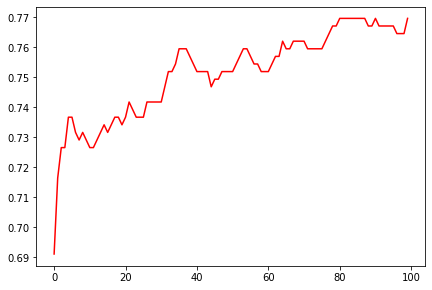

In [114]:
plot(ndcg_record)

# Evaluation
> order:`precision, recall, f1_score`
- 实际：标注数据，预测：predict之后的top3
    - TP(True Positive) 真阳性：预测为正，实际也为正
    - FP(False Positive) 假阳性：预测为正，实际为负
    - FN(False Negative) 假阴性：预测为负、实际为正
    - TN(True Negative) 真阴性：预测为负、实际也为负
    - P(Precision) 精确率 P = TP/(TP+FP)
    - R(Recall) 召回率 R = TP/(TP+FN)
    - F(f1-score) F-值 F = 2PR/(P+R)
    - ACC=(TP+TN)/(TP+FP+TN+FN)

In [115]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [116]:
test_pred_result, test_pred_score = rank.handler.predict(test,k)
y_test_true = test[:, 0].astype(np.int32).tolist()
y_test_score = test_pred_score
benchmark_pred_result, benchmark_pred_score = rank.handler.predict(benchmark,k)
y_bench_true = benchmark[:,0].astype(np.int32).tolist()
y_bench_score = benchmark_pred_score
print(len(y_bench_true), len(y_bench_score))

2619 2619


In [117]:
def performance_measure(y_true, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    precision_list, recall_list, thresholds = precision_recall_curve(y_true, y_score, pos_label=None, sample_weight=None)
    ap = average_precision_score(y_true, y_score, average='macro', pos_label=1, sample_weight=None)
    
    #Plot of a PR curve with thresholds
    plt.figure()
    lw = 2
    plt.plot(thresholds, precision_list[:-1], color='darkorange', lw=lw, label='Precision curve (avg = %0.2f)' % ap)
    plt.plot(thresholds, recall_list[:-1], color='navy', lw=lw, linestyle='--', label='Recall curve')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.0])
    plt.xlabel('thresholds')
    plt.ylabel('P/R')
    plt.title('Precision&Recall thresholds Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    #Plot of a PR curve
    plt.figure()
    lw = 2
    plt.plot(precision_list[:-1], recall_list[:-1], color='darkorange', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('P')
    plt.ylabel('R')
    plt.title('PR Curve')
    plt.show()
    
    #plot f1-score
    f_list = []
    for i in range(0, len(thresholds)):
        # 2PR/(P+R)
        f_list.append(2*precision_list[i]*recall_list[i]/(precision_list[i]+recall_list[i]))
    plt.figure()
    lw = 2
    plt.plot(thresholds, f_list, color='darkorange', lw=lw)
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.0])
    plt.xlabel('thresholds')
    plt.ylabel('F-score')
    plt.title('F/thresholds Curve')
    plt.show()
    return precision_list, recall_list, f_list, thresholds, ap

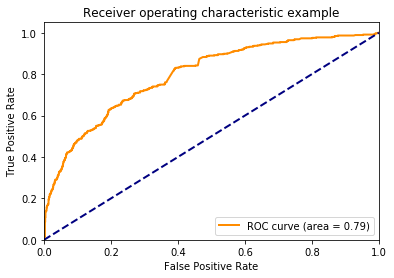

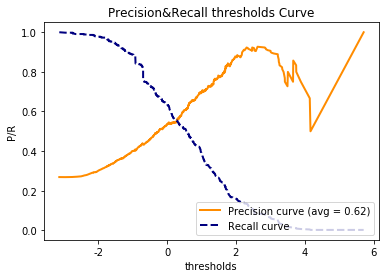

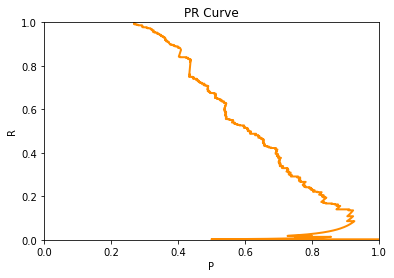

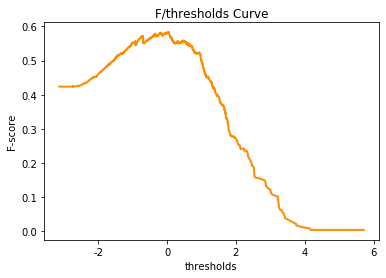

In [118]:
test_res = performance_measure(y_test_true, y_test_score)

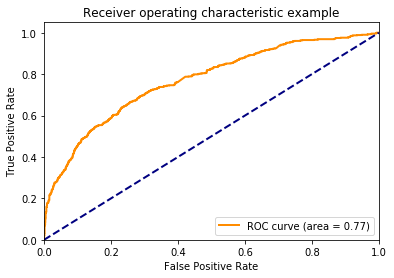

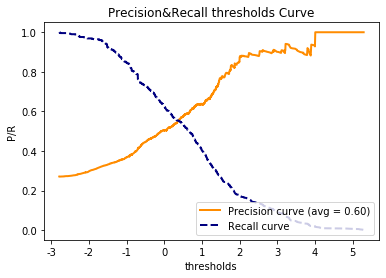

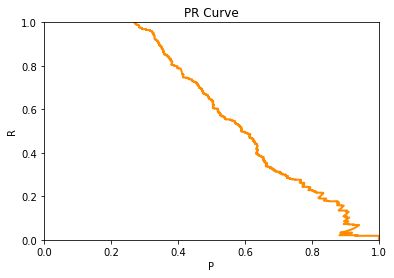

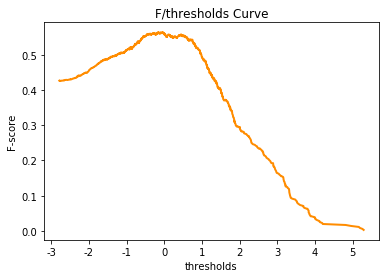

In [119]:
bench_res = performance_measure(y_bench_true, y_bench_score)

# threshold --> entity

In [36]:
precision_list, recall_list, thresholds = precision_recall_curve(y_test_true, y_test_score, pos_label=None, sample_weight=None)

In [68]:
thres_entity_propor = {}
for thres in thresholds.tolist():
    i = 0
    for value in test_pred_result.values():
        if value[0][1]>thres:
            i += 1
    thres_entity_propor[thres] = i/len(list(test_pred_result.keys()))

In [72]:
thres_entity_num = {}
for thres in thresholds.tolist():
    i = 0
    for value in test_pred_result.values():
        if value[0][1]>thres:
            i += 1
    thres_entity_num[thres] = i

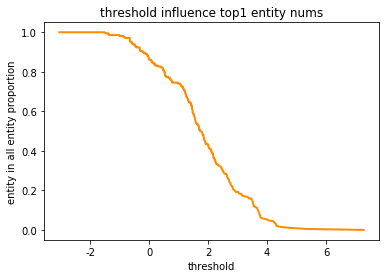

In [74]:
plt.figure()
lw =2
plt.plot(list(thres_entity_propor.keys()), list(thres_entity_propor.values()), color='darkorange', lw=lw)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
plt.xlabel('threshold')
plt.ylabel('entity in all entity proportion')
plt.title('threshold influence top1 entity nums')
plt.show()

# how many relation(1 relation contains 1 entities) per paper?

In [84]:
f_pqid = open('data/pqid.txt', 'r', encoding='utf8')
qid = {}
idq = {}
flag = 0
for line in f_pqid:
    c = line[:-1].replace("\"","").split('\t')
    qid[str(c[0]) + "@" + str(c[1])] = flag
    idq[flag] = str(c[0]) + "@" + str(c[1])
    flag += 1

In [103]:
thres_avg_per_paper_realtion_num={}
for thres in thresholds.tolist():
    relation_len = 0
    paper_relation = {}
    for key in test_pred_result.keys():
        if test_pred_result[key][0][1]>thres:
            paper_id = idq[key].split('@')[0]
            relation = idq[key].split('@')[1]
            paper_relation.setdefault(paper_id,set())
            paper_relation[paper_id].add(relation)
    for value in paper_relation.values():
        relation_len += len(value)
    if len(list(paper_relation.keys()))==0:
        thres_avg_per_paper_realtion_num[thres] = 0
    else:
        thres_avg_per_paper_realtion_num[thres] = relation_len/len(list(paper_relation.keys()))

In [104]:
thres_avg_per_paper_realtion_num

{-3.0551159381866455: 4.16,
 -2.7893598079681396: 4.16,
 -2.781100273132324: 4.16,
 -2.633134126663208: 4.16,
 -2.5786850452423096: 4.16,
 -2.5785205364227295: 4.16,
 -2.5733699798583984: 4.16,
 -2.569298267364502: 4.16,
 -2.568042755126953: 4.16,
 -2.5648539066314697: 4.16,
 -2.5647974014282227: 4.16,
 -2.5645129680633545: 4.16,
 -2.5640714168548584: 4.16,
 -2.561119794845581: 4.16,
 -2.560495376586914: 4.16,
 -2.558854103088379: 4.16,
 -2.5486676692962646: 4.16,
 -2.496904134750366: 4.16,
 -2.471482038497925: 4.16,
 -2.4536006450653076: 4.16,
 -2.4494717121124268: 4.16,
 -2.448699951171875: 4.16,
 -2.4475624561309814: 4.16,
 -2.4431564807891846: 4.16,
 -2.4348671436309814: 4.16,
 -2.4304540157318115: 4.16,
 -2.3832573890686035: 4.16,
 -2.3795833587646484: 4.16,
 -2.3745276927948: 4.16,
 -2.367854356765747: 4.16,
 -2.3424055576324463: 4.16,
 -2.338122844696045: 4.16,
 -2.3312995433807373: 4.16,
 -2.3224282264709473: 4.16,
 -2.299246072769165: 4.16,
 -2.2981579303741455: 4.16,
 -2.2899

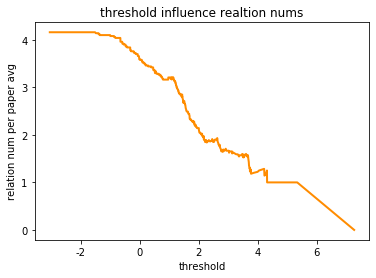

In [105]:
plt.figure()
lw =2
plt.plot(list(thres_avg_per_paper_realtion_num.keys()), list(thres_avg_per_paper_realtion_num.values()), color='darkorange', lw=lw)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
plt.xlabel('threshold')
plt.ylabel('relation num per paper avg')
plt.title('threshold influence realtion nums')
plt.show()

## Top 1 or 3

In [26]:
test_true_result = test[:, [2, 0]].astype(np.int32).tolist()
test_evaluate = evaluate(test_pred_result,test_true_result)

factors in predict
precision: 0.4527972027972028,
recall: 0.5846501128668171,
f1_score: 0.5103448275862068,
accuracy: 0.698605215281989


In [27]:
benchmark_true_result = benchmark[:,[2,0]].astype(np.int32).tolist()
benchmark_evaluate = evaluate(benchmark_pred_result,benchmark_true_result)

factors in predict
precision: 0.5712484237074401,
recall: 0.6416430594900849,
f1_score: 0.6044029352901934,
accuracy: 0.773577701412753
